In [32]:
from datasets import load_dataset, load_from_disk
from collections import defaultdict
import random
import tqdm

In [3]:
dataset = load_dataset("IlyaGusev/rulm")

No config specified, defaulting to: rulm/default
Found cached dataset rulm (/home/jovyan/.cache/huggingface/datasets/IlyaGusev___rulm/default/0.0.1/c94da05286e8839c1219f9a5061c630709a487fb298427a6f5a73ee0fe2cd2cb)


  0%|          | 0/3 [00:00<?, ?it/s]

In [225]:
i = 0
for s in dataset["train"]:
    if s["meta"]["source"] == "librusec":
        if i == 297:
            # print(s["text"])
            break
        i += 1

In [4]:
dataset_filtered = dataset.filter(lambda x: x["meta"]["source"] not in ("pikabu", "wiki"))

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/IlyaGusev___rulm/default/0.0.1/c94da05286e8839c1219f9a5061c630709a487fb298427a6f5a73ee0fe2cd2cb/cache-06a3d6f1322569ec.arrow
Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/IlyaGusev___rulm/default/0.0.1/c94da05286e8839c1219f9a5061c630709a487fb298427a6f5a73ee0fe2cd2cb/cache-6749c8629a964007.arrow
Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/IlyaGusev___rulm/default/0.0.1/c94da05286e8839c1219f9a5061c630709a487fb298427a6f5a73ee0fe2cd2cb/cache-f27c9c5a803bed04.arrow


In [5]:
sources = [(s["meta"]["source"], len(s["text"])) for s in tqdm.tqdm(dataset_filtered["train"], total=dataset_filtered["train"].num_rows)]

100%|██████████| 10943685/10943685 [13:21<00:00, 13656.99it/s]


In [7]:
source_texts = defaultdict(list)

for i, (src, text_len) in tqdm.tqdm(enumerate(sources), total=len(sources)):
    source_texts[src].append((i, text_len))

100%|██████████| 10943685/10943685 [00:06<00:00, 1750946.59it/s]


In [9]:
source_texts_count = {s: len(texts) for s, texts in tqdm.tqdm(source_texts.items())}
source_texts_len = {s: sum(map(lambda x: x[1], texts)) for s, texts in tqdm.tqdm(source_texts.items())}


100%|██████████| 10/10 [00:00<00:00, 169125.16it/s]

100%|██████████| 10/10 [00:01<00:00,  5.04it/s][A


In [11]:
source_texts_count

{'lenta': 748299,
 'stihi': 5099823,
 'stackoverflow': 419383,
 'habr': 294461,
 'taiga_fontanka': 315449,
 'librusec': 1398319,
 'buriy': 1494355,
 'ods_tass': 1104120,
 'gazeta': 58447,
 'math': 11029}

<BarContainer object of 10 artists>

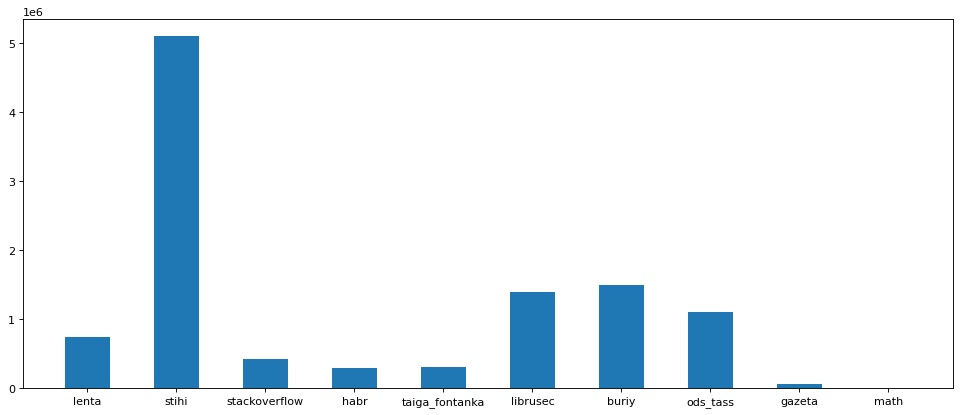

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6), dpi=80)
plt.bar(source_texts_count.keys(), source_texts_count.values(), 0.5)

<BarContainer object of 10 artists>

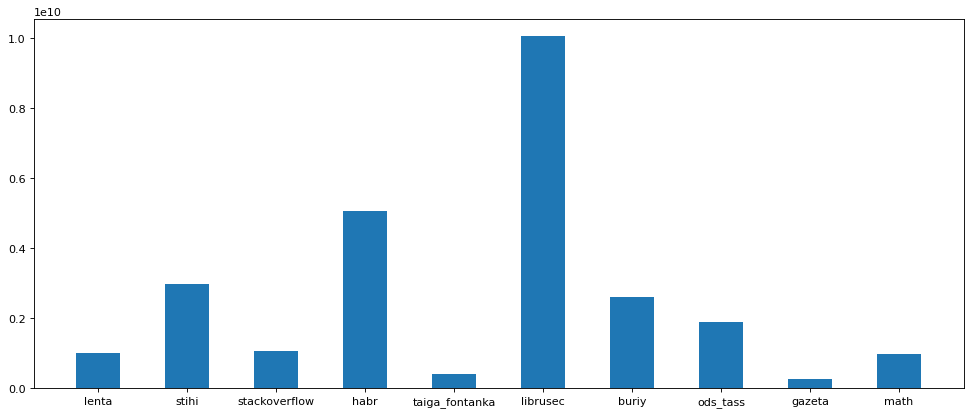

In [198]:
plt.figure(figsize=(15, 6), dpi=80)
plt.bar(source_texts_len.keys(), source_texts_len.values(), 0.5)

In [199]:
def sample_indices(source_percentage: dict[str, float]):
    chosen_indices = {}

    for source, percent in source_percentage.items():
        source_samples = int(len(source_texts[source]) * percent)
        chosen_indices[source] = random.sample(source_texts[source], source_samples)

    return chosen_indices

In [206]:
source_percentage = {
    "lenta": 0.15,
    "stihi": 0.1,
    "stackoverflow": 0.8,
    "habr": 0.2,
    "taiga_fontanka": 0.5,
    "librusec": 0.1,
    "buriy": 0.08,
    "ods_tass": 0.12,
    "gazeta": 0.5,
    "math": 0.28,
}

In [207]:
source_texts_count["stackoverflow"] * source_percentage["stackoverflow"]

335506.4

In [208]:
source_texts_count["lenta"] * source_percentage["lenta"] + source_texts_count["taiga_fontanka"] * source_percentage["taiga_fontanka"] + \
    source_texts_count["ods_tass"] * source_percentage["ods_tass"] + source_texts_count["buriy"] * source_percentage["buriy"] + \
    source_texts_count["gazeta"] * source_percentage["gazeta"]

551235.65

In [209]:
chosen_indices = sample_indices(source_percentage)

In [220]:
chosen_indices_len_dist

{'lenta': 149715465,
 'stihi': 295809244,
 'stackoverflow': 849608472,
 'habr': 1006100234,
 'taiga_fontanka': 207969334,
 'librusec': 1004078191,
 'buriy': 208611522,
 'ods_tass': 226031879,
 'gazeta': 133107751,
 'math': 273877993}

<BarContainer object of 10 artists>

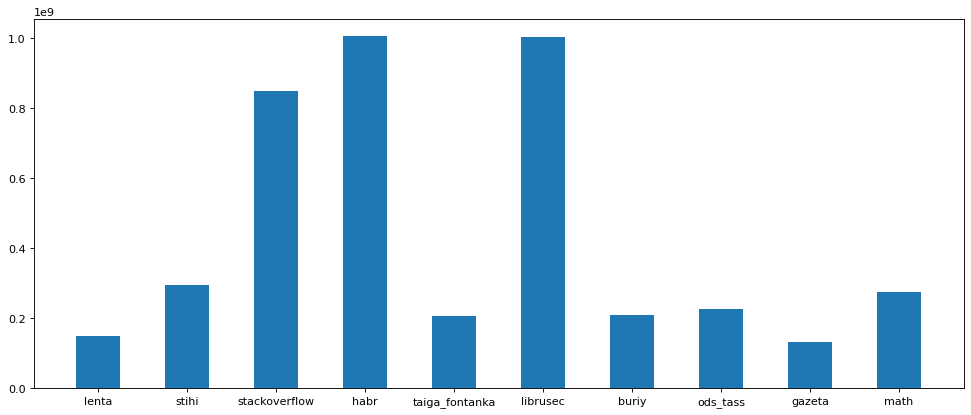

In [211]:
plt.figure(figsize=(15, 6), dpi=80)

chosen_indices_len_dist = {s: sum(map(lambda x: x[1], texts)) for s, texts in chosen_indices.items()}

plt.bar(chosen_indices_len_dist.keys(), chosen_indices_len_dist.values(), 0.5)

In [212]:
total_chosen_indices = []
for s, texts in chosen_indices.items():
    for i, text_len in texts:
        total_chosen_indices.append(i)

In [213]:
len(total_chosen_indices)

1598532

In [214]:
selected_dataset = dataset_filtered["train"].select(total_chosen_indices)

In [215]:
selected_dataset = selected_dataset.shuffle(seed=42)

In [216]:
selected_dataset = selected_dataset.train_test_split(test_size=0.05)

In [218]:
selected_dataset.save_to_disk("filtered_dataset")

Saving the dataset (0/17 shards):   0%|          | 0/1518605 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/79927 [00:00<?, ? examples/s]

In [219]:
!du -hs filtered_dataset

6.9G	filtered_dataset


In [228]:
from transformers import LlamaTokenizer
tokenizer = LlamaTokenizer.from_pretrained("hf-internal-testing/llama-tokenizer")

In [229]:
def tokenize(prompt, add_eos_token=True):
    result = tokenizer(prompt)
    if (
        result["input_ids"][-1] != tokenizer.eos_token_id
        and add_eos_token
    ):
        result["input_ids"].append(tokenizer.eos_token_id)
        result["attention_mask"].append(1)

    return result

In [244]:
from itertools import chain

In [280]:
def chunk_examples(examples, max_length):
    input_ids_chunks = []
    attention_mask_chunks = []
    
    input_ids = list(chain(*examples["input_ids"]))
    attention_mask = list(chain(*examples["attention_mask"]))
    input_ids_chunks.extend(
        [
            input_ids[i : i + max_length]
            for i in range(0, len(input_ids), max_length)
        ]
    )
    attention_mask_chunks.extend(
        [
            attention_mask[i : i + max_length]
            for i in range(0, len(attention_mask), max_length)
        ]
    )
    
    return {
        "input_ids": input_ids_chunks,
        "attention_mask": attention_mask_chunks,
    }

In [281]:
selected_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'meta'],
        num_rows: 1518605
    })
    test: Dataset({
        features: ['text', 'meta'],
        num_rows: 79927
    })
})

In [282]:
def prepare_dataset(dataset, num_proc=8, max_seq_len=512, tokenizer_bs=100):
    tokenized_dataset = dataset.map(lambda x: tokenize(x['text']),
                                    num_proc=num_proc, remove_columns=["meta"])
    
    chunk_dataset = tokenized_dataset.map(lambda x: chunk_examples(x, max_seq_len), 
                                          batched=True, 
                                          batch_size=tokenizer_bs,
                                          num_proc=num_proc,
                                          remove_columns=["text"])
    return tokenized_dataset, chunk_dataset

In [285]:
tokenized_dataset = prepare_dataset(selected_dataset)

Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/IlyaGusev___rulm/default/0.0.1/c94da05286e8839c1219f9a5061c630709a487fb298427a6f5a73ee0fe2cd2cb/cache-3636ca769c33250c_*_of_00008.arrow
Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/IlyaGusev___rulm/default/0.0.1/c94da05286e8839c1219f9a5061c630709a487fb298427a6f5a73ee0fe2cd2cb/cache-f297281e270daca3_*_of_00008.arrow
Loading cached processed dataset at /home/jovyan/.cache/huggingface/datasets/IlyaGusev___rulm/default/0.0.1/c94da05286e8839c1219f9a5061c630709a487fb298427a6f5a73ee0fe2cd2cb/cache-c8615b0feb2e05ef_*_of_00008.arrow


Map (num_proc=8):   0%|          | 0/79927 [00:00<?, ? examples/s]

In [287]:
tokenized_dataset

(DatasetDict({
     train: Dataset({
         features: ['text', 'input_ids', 'attention_mask'],
         num_rows: 1518605
     })
     test: Dataset({
         features: ['text', 'input_ids', 'attention_mask'],
         num_rows: 79927
     })
 }),
 DatasetDict({
     train: Dataset({
         features: ['input_ids', 'attention_mask'],
         num_rows: 3204080
     })
     test: Dataset({
         features: ['input_ids', 'attention_mask'],
         num_rows: 170263
     })
 }))

In [290]:
tokenized_dataset[1].save_to_disk("filtered_tokenized_dataset")

Saving the dataset (0/17 shards):   0%|          | 0/3204080 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/170263 [00:00<?, ? examples/s]

In [291]:
print("lol")

lol


In [289]:
!ls

Untitled.ipynb	  logs		      requirements.txt	train.ipynb
chunk_dataset	  mlruns	      test.ipynb	trained
filtered_dataset  prepare_data.ipynb  train-new.py	zero_config.json
